[INFO] Using frames with TIMESTEP in [8000000, 10650000]
[INFO] z-centers: 6.0, 10.5, 37.0
[INFO] autodetected species types: {'Na⁺': [2], 'FSI⁻': [4], 'DFM': [16], 'ME2O': [8]}
[INFO] accumulating for atom types: [2, 4, 8, 16]
[INFO] dx=0.342 Å, dy=0.321 Å


Accumulate XY density: 663it [00:15, 43.14it/s]
/tmp/ipykernel_2833847/3511380905.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)
/tmp/ipykernel_2833847/3511380905.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)


[INFO] saved xy_density_multi.npz
[CHECK] Na⁺   z=  6.0 Å  N2D=    1.3857, ∫px dx=    1.3857, ∫py dy=    1.3857  |Δx|=2.220e-16, |Δy|=0.000e+00
[CHECK] FSI⁻  z=  6.0 Å  N2D=    0.3680, ∫px dx=    0.3680, ∫py dy=    0.3680  |Δx|=5.551e-17, |Δy|=1.110e-16


/tmp/ipykernel_2833847/3511380905.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)
/tmp/ipykernel_2833847/3511380905.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)
/tmp/ipykernel_2833847/3511380905.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)
/tmp/ipykernel_2833847/3511380905.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 

[CHECK] DFM   z=  6.0 Å  N2D=   21.2426, ∫px dx=   21.2426, ∫py dy=   21.2426  |Δx|=0.000e+00, |Δy|=1.066e-14
[CHECK] ME2O  z=  6.0 Å  N2D=    8.4200, ∫px dx=    8.4200, ∫py dy=    8.4200  |Δx|=1.776e-15, |Δy|=7.105e-15
[CHECK] Na⁺   z= 10.5 Å  N2D=    1.2489, ∫px dx=    1.2489, ∫py dy=    1.2489  |Δx|=0.000e+00, |Δy|=0.000e+00
[CHECK] FSI⁻  z= 10.5 Å  N2D=    1.4173, ∫px dx=    1.4173, ∫py dy=    1.4173  |Δx|=0.000e+00, |Δy|=2.220e-16
[CHECK] DFM   z= 10.5 Å  N2D=   25.1888, ∫px dx=   25.1888, ∫py dy=   25.1888  |Δx|=3.553e-15, |Δy|=3.553e-15
[CHECK] ME2O  z= 10.5 Å  N2D=    6.1736, ∫px dx=    6.1736, ∫py dy=    6.1736  |Δx|=3.553e-15, |Δy|=4.441e-15
[CHECK] Na⁺   z= 37.0 Å  N2D=    1.4672, ∫px dx=    1.4672, ∫py dy=    1.4672  |Δx|=2.220e-16, |Δy|=2.220e-16
[CHECK] FSI⁻  z= 37.0 Å  N2D=    1.5239, ∫px dx=    1.5239, ∫py dy=    1.5239  |Δx|=0.000e+00, |Δy|=0.000e+00
[CHECK] DFM   z= 37.0 Å  N2D=   25.1494, ∫px dx=   25.1494, ∫py dy=   25.1494  |Δx|=7.105e-15, |Δy|=7.105e-15
[CHECK] ME

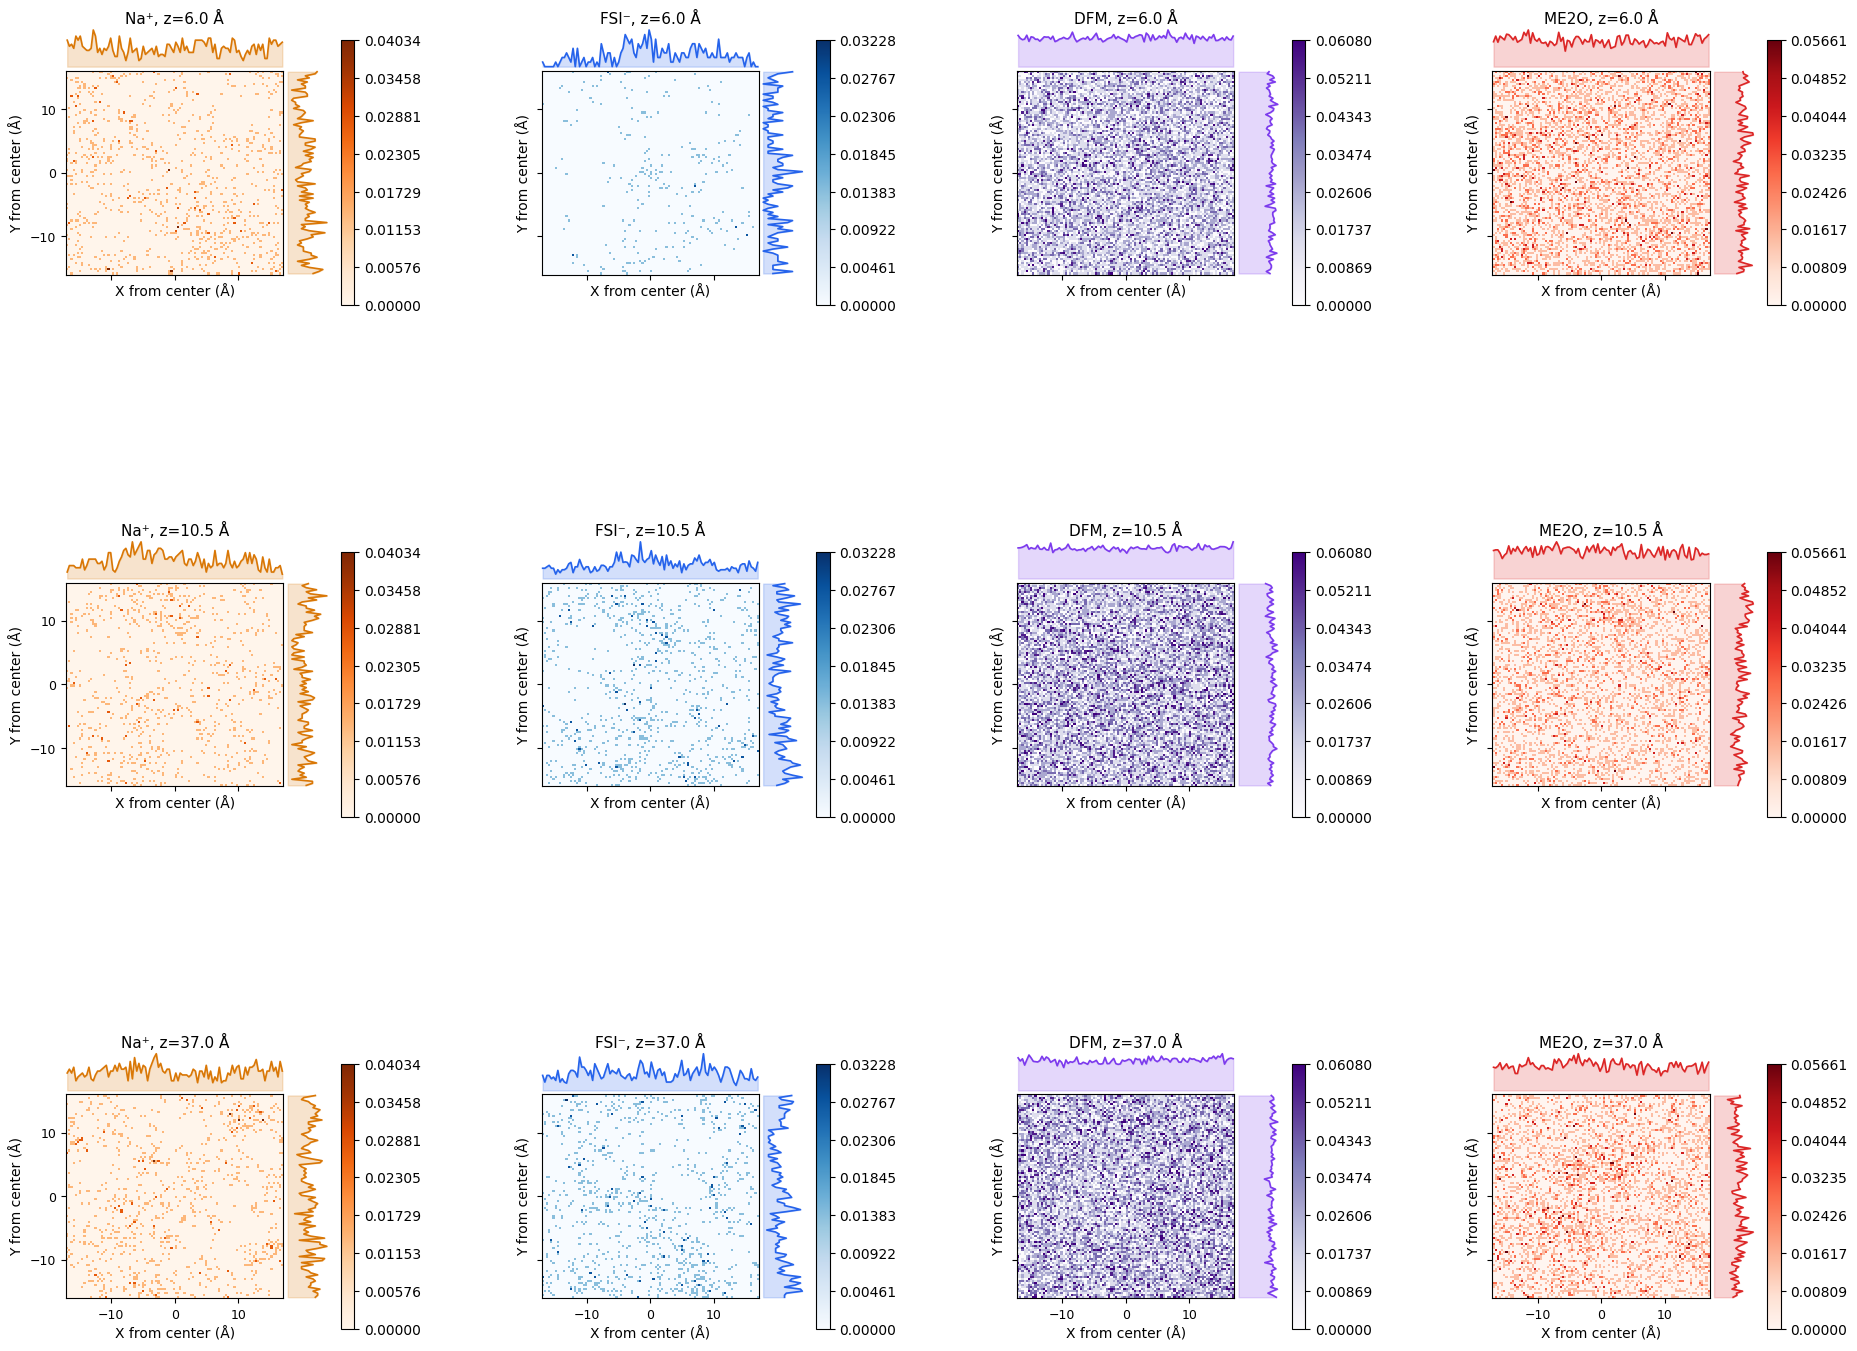

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
2D XY number density slices (timestep windowed, Ramachandran-style marginals OUTSIDE)

"""

import json, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Sequence, Dict, List
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.transforms import blended_transform_factory as blend

# ───────── user config ─────────
TRAJ = "analysis_nvt.lammpstrj"
META_JSON = "peaks_meta.json"
NPZ_OUT   = "xy_density_multi.npz"

ELECTRODE_TYPES_SAME = [1]
BOTTOM_PCT = 95.0
DZ_SLICE = 2.5
NX = NY = 100

# ──Species type ──
TYPE_CANDIDATES = {
    "Na⁺":  [2],
    "FSI⁻": [4],  
    "DFM":  [16],   
    "ME2O": [8],     
}

# FSI peak 
FSI_PEAK_Z = 6.0  

# fixed scale
FIXED_VMAX_BY_LABEL = {
    "Na⁺":  0.04034,
    "FSI⁻": 0.03228,
    "DFM":  0.06080,
    "ME2O": 0.05661,
}
VMIN = 0.0
COLORBAR_TICKS = 8

# Marginal band setup
TOP_FRAC, RIGHT_FRAC = 0.18, 0.18
MARGINAL_ALPHA = 0.2
MARGINAL_STYLE = {
    "Na⁺":  dict(color="#d97706", lw=1.2),
    "FSI⁻": dict(color="#2563eb", lw=1.2),
    "DFM":  dict(color="#7c3aed", lw=1.2),
    "ME2O": dict(color="#dc2626", lw=1.2),
}

# Shift
TITLE_PAD = 34
CB_PAD = 0.20
LABEL_XSHIFT = 1.55
OUTSIDE_TOP_GAP_FRAC = 0.02
OUTSIDE_RIGHT_GAP_FRAC = 0.02

# timestep window
DT_FS = 1.0
TIME_WINDOW_NS = (8.0, 10.65)
START_TS = None
END_TS   = None
SORT_Z_ASC = True
# ───────────────────────────────

def parse_lammps_frame(frame_lines):
    data={'bounds':{}, 'atoms':[]}
    it=iter(frame_lines)
    try:
        while True:
            line=next(it).strip()
            if line.startswith("ITEM: BOX BOUNDS"):
                data['bounds']['x']=list(map(float, next(it).split()))
                data['bounds']['y']=list(map(float, next(it).split()))
                data['bounds']['z']=list(map(float, next(it).split()))
            elif line.startswith("ITEM: ATOMS"):
                cols=line.split()[2:]
                idx_type=cols.index('type')
                coord={}
                for d in ('x','y','z'):
                    for suf in ('','s','u'):
                        k=d+suf
                        if k in cols: coord[d]=cols.index(k); break
                for ln in it:
                    sp=ln.split()
                    if len(sp)<=max(coord.values()): continue
                    data['atoms'].append((
                        int(float(sp[idx_type])),
                        float(sp[coord['x']]),
                        float(sp[coord['y']]),
                        float(sp[coord['z']])
                    ))
                break
    except StopIteration:
        pass
    if not data['bounds'] or not data['atoms']: return None
    a=np.array(data['atoms'], float); a[:,0]=a[:,0].astype(int); data['atoms']=a
    return data

def read_lammps_frames_window(filename, start_ts=None, end_ts=None):
    buf=[]; current_ts=None
    with open(filename) as f:
        for line in f:
            if line.startswith("ITEM: TIMESTEP"):
                if buf and (current_ts is not None):
                    if ((start_ts is None or current_ts >= start_ts) and
                        (end_ts   is None or current_ts <= end_ts)):
                        yield buf
                buf=[line]
                ts_line = next(f)
                current_ts = int(ts_line.strip())
                buf.append(ts_line)
            else:
                buf.append(line)
        if buf and (current_ts is not None):
            if ((start_ts is None or current_ts >= start_ts) and
                (end_ts   is None or current_ts <= end_ts)):
                yield buf

def bottom_surface_by_median_split(z_all: np.ndarray, pct: float) -> float:
    zmid=np.median(z_all)
    lower=z_all[z_all<=zmid]
    if lower.size==0:
        order=np.argsort(z_all); half=len(order)//2
        m=np.zeros_like(z_all,dtype=bool); m[order[:half]]=True
        lower=z_all[m]
    return float(np.percentile(lower, pct))

def ztag(z: float) -> str:
    return f"{z:.2f}".replace('.','p').replace('-','m')

def get_cmap(name):
    base = cm.get_cmap(name)
    try:
        return base.with_extremes(over=base(1.0), under=base(0.0), bad=(1,1,1,0))
    except AttributeError:
        base = base.copy(); base.set_over(base(1.0)); base.set_under(base(0.0)); base.set_bad((1,1,1,0))
        return base

def load_targets_from_meta(path: str):
    with open(path, "r", encoding="utf-8") as f:
        m = json.load(f)
    zlist = m.get("z_centers_used")
    if isinstance(zlist, list) and zlist:
        zc = [float(f"{float(v):.1f}") for v in zlist]
        if "bulk_mid" in m:
            bm = float(f"{float(m['bulk_mid']):.2f}")
            if bm not in zc: zc.append(bm)
        return sorted(dict.fromkeys(zc)), m
    zc=[]
    if "bot_peak_Na" in m: zc.append(float(f"{float(m['bot_peak_Na']):.1f}"))
    elif "bot_peak" in m:  zc.append(float(f"{float(m['bot_peak']):.1f}"))
    if "bulk_mid" in m:    zc.append(float(f"{float(m['bulk_mid']):.2f}"))
    pref=m.get("anion_peak_ref","bottom"); an_key=None
    if pref in ("bottom","both") and "bot_peak_FSI" in m: an_key="bot_peak_FSI"
    elif "top_peak_FSI" in m: an_key="top_peak_FSI"
    elif "top_peak" in m: an_key="top_peak"
    if an_key: zc.append(float(f"{float(m[an_key]):.1f}"))
    extra = m.get("extra_slices", [])
    if isinstance(extra, list):
        zc.extend(float(f"{float(v):.1f}") for v in extra)
    return sorted(dict.fromkeys(zc)), m

# ── Auto detecting specie types from first frame ── 
def autodetect_types(traj_file: str, start_ts=None, end_ts=None) -> Dict[str, List[int]]:
    present = set()
    for fr in read_lammps_frames_window(traj_file, start_ts, end_ts):
        meta = parse_lammps_frame(fr)
        if meta is None: continue
        present = set(meta['atoms'][:,0].astype(int).tolist())
        break
    chosen = {}
    for lbl, cands in TYPE_CANDIDATES.items():
        picks = [t for t in cands if t in present]
        chosen[lbl] = picks  # No list if none
    print("[INFO] autodetected species types:", {k: v for k, v in chosen.items()})
    return chosen

def accumulate_xy(
    traj_file: str,
    atom_types: Sequence[int],
    z_centers: Sequence[float],
    nx: int,
    ny: int,
    dz: float,
    start_ts=None,
    end_ts=None
):
    # ─── set grid from first timestep ───
    first = None
    for fr in read_lammps_frames_window(traj_file, start_ts, end_ts):
        first = parse_lammps_frame(fr)
        if first:
            break
    if first is None:
        raise RuntimeError("No frames in the selected timestep window.")

    xlo, xhi = first["bounds"]["x"]
    ylo, yhi = first["bounds"]["y"]
    Lx, Ly = xhi - xlo, yhi - ylo
    x_edges = np.linspace(xlo, xhi, nx + 1)
    y_edges = np.linspace(ylo, yhi, ny + 1)
    dx, dy = Lx / nx, Ly / ny
    print(f"[INFO] dx={dx:.3f} Å, dy={dy:.3f} Å")

    # ─── PBC wrapping function ───
    def wrap_xy(x, lo, hi):
        L = hi - lo
        return lo + np.mod(x - lo, L)
    counts = {(at, z0): np.zeros((nx, ny), float) for at in atom_types for z0 in z_centers}
    nframes = {(at, z0): 0 for at in atom_types for z0 in z_centers}

    # ─── frame loop ───
    for fr in tqdm(read_lammps_frames_window(traj_file, start_ts, end_ts), desc="Accumulate XY density"):
        meta = parse_lammps_frame(fr)
        if meta is None:
            continue

        a = meta["atoms"]
        types = a[:, 0].astype(int)
        z = a[:, 3]
        z_elec = z[np.isin(types, ELECTRODE_TYPES_SAME)]
        if z_elec.size == 0:
            continue
        for at in atom_types:
            for z0 in z_centers:
                nframes[(at, z0)] += 1

        # PBC wrapping
        x = wrap_xy(a[:, 1], xlo, xhi)
        y = wrap_xy(a[:, 2], ylo, yhi)

        # bottom surface
        z_bot = bottom_surface_by_median_split(z_elec, BOTTOM_PCT)

        # ───Loop for types ───
        for at in atom_types:
            m_at = (types == at)
            if not np.any(m_at):
                continue
            xa, ya, za = x[m_at], y[m_at], z[m_at]

            # ─── z slice loop ───
            for z0 in z_centers:
                zmin = z_bot + (z0 - dz / 2.0)
                zmax = z_bot + (z0 + dz / 2.0)
                m_slice = (za >= zmin) & (za < zmax)
                if not np.any(m_slice):
                    continue

                # calculate and cumulative histogram
                H, _, _ = np.histogram2d(
                    xa[m_slice], ya[m_slice],
                    bins=[x_edges, y_edges]
                )
                counts[(at, z0)] += H

    # ─── time average and normalization ───
    area = dx * dy
    out = {
        "x_edges": x_edges,
        "y_edges": y_edges,
        "z_centers_used": np.array(z_centers, float),
        "timestep_window": np.array([start_ts, end_ts], int),
    }

    for (at, z0), H in counts.items():
        n = max(1, nframes[(at, z0)])  
        dens = (H / n) / area
        out[f"type{int(at)}_z{ztag(z0)}"] = dens

    return out
# ───── marginals OUTSIDE ─────
def add_marginals_outside(
    ax, x_edges, y_edges, dens2d, species_name,
    top_frac=TOP_FRAC, right_frac=RIGHT_FRAC, alpha=MARGINAL_ALPHA, y_locator=None,
    outside_top_gap_frac=OUTSIDE_TOP_GAP_FRAC,
    outside_right_gap_frac=OUTSIDE_RIGHT_GAP_FRAC
):
    Z = dens2d.T if dens2d.shape[0] == len(x_edges)-1 else dens2d
    nx, ny = len(x_edges)-1, len(y_edges)-1
    assert Z.shape == (ny, nx)

    dx = np.diff(x_edges)[0];  dy = np.diff(y_edges)[0]
    xc = 0.5*(x_edges[:-1] + x_edges[1:])
    yc = 0.5*(y_edges[:-1] + y_edges[1:])

    px = Z.sum(axis=0) * dy
    py = Z.sum(axis=1) * dx
    pxn = px / (px.max() if px.max() > 0 else 1.0)
    pyn = py / (py.max() if py.max() > 0 else 1.0)

    st = MARGINAL_STYLE.get(species_name, dict(color="#888", lw=1.2))
    col, lw = st["color"], st.get("lw", 1.2)

    tx_top   = blend(ax.transData, ax.transAxes)  # x=data, y=axes(0..1)
    tx_right = blend(ax.transAxes, ax.transData)  # x=axes(0..1), y=data

    # Top band
    y0 = 1.0 + outside_top_gap_frac
    y_plot = y0 + top_frac * pxn
    poly = ax.fill_between(xc, y0, y_plot, color=col, alpha=alpha, clip_on=False); poly.set_transform(tx_top)
    line, = ax.plot(xc, y_plot, color=col, lw=lw); line.set_transform(tx_top); line.set_clip_on(False)

    # Right band
    x0 = 1.0 + outside_right_gap_frac
    x_plot = x0 + right_frac * pyn
    poly2 = ax.fill_betweenx(yc, x0, x_plot, color=col, alpha=alpha, clip_on=False); poly2.set_transform(tx_right)
    line2, = ax.plot(x_plot, yc, color=col, lw=lw); line2.set_transform(tx_right); line2.set_clip_on(False)

    if y_locator is not None:
        ax.yaxis.set_major_locator(y_locator)

    # Integration check
    N2D = Z.sum() * dx * dy
    Nx  = px.sum() * (xc[1]-xc[0])
    Ny  = py.sum() * (yc[1]-yc[0])
    return N2D, Nx, Ny

# ──────────────────────────────── main ───────────────────────────────
if __name__ == "__main__":
    # timestep window 계산
    if START_TS is None or END_TS is None:
        steps_per_ns = 1_000_000.0 / float(DT_FS)
        START_TS = int(round(TIME_WINDOW_NS[0] * steps_per_ns))
        END_TS   = int(round(TIME_WINDOW_NS[1] * steps_per_ns))
    print(f"[INFO] Using frames with TIMESTEP in [{START_TS}, {END_TS}]")

    # z-centers + FSI 5.1 Å 
    z_centers, meta = load_targets_from_meta(META_JSON)
    if FSI_PEAK_Z is not None:
        zf = float(f"{float(FSI_PEAK_Z):.1f}")
        z_centers.append(zf)

    z_centers = sorted(dict.fromkeys(z_centers)) if SORT_Z_ASC else list(dict.fromkeys(z_centers))
    if not z_centers:
        raise RuntimeError("No z-centers loaded/constructed.")
    print("[INFO] z-centers:", ", ".join(f"{z:.1f}" for z in z_centers))

    # Automatic detection of species type → Creation of species list
    chosen = autodetect_types(TRAJ, START_TS, END_TS)
    species = [
        ("Na⁺",  chosen.get("Na⁺", []),   "Oranges"),
        ("FSI⁻", chosen.get("FSI⁻", []),  "Blues"),
        ("DFM",  chosen.get("DFM", []),   "Purples"),
        ("ME2O", chosen.get("ME2O", []),  "Reds"),
    ]
    # The union of atom types to be used for accumulation.
    ATOM_TYPES = sorted({t for _, ts, _ in species for t in ts})
    if not ATOM_TYPES:
        raise RuntimeError("No atom types detected for selected species.")
    print("[INFO] accumulating for atom types:", ATOM_TYPES)

    # Accumulate
    npz_dict = accumulate_xy(
        TRAJ, ATOM_TYPES, z_centers, NX, NY, DZ_SLICE,
        start_ts=START_TS, end_ts=END_TS
    )
    # Update meta
    npz_dict.update({
        "fsi_peak_z": None if FSI_PEAK_Z is None else float(f"{float(FSI_PEAK_Z):.1f}"),
        "species_types_json": json.dumps({lbl: ts for lbl, ts, _ in species}),
    })
    for k,v in meta.items():
        if k == "z_centers_used":   
            continue
        if isinstance(v, list):
            v = np.array(v, float) if (not v) or isinstance(v[0], (int,float)) else np.array(v, object)
        npz_dict[k]=v
    np.savez(NPZ_OUT, **npz_dict)
    print(f"[INFO] saved {NPZ_OUT}")

    # ───────── Plot ─────────
    data = np.load(NPZ_OUT)  
    x_edges, y_edges = data["x_edges"], data["y_edges"]

    
    if "z_centers_used_from_loader" in data.files:
        z_centers = list(np.asarray(data["z_centers_used_from_loader"], float))
    else:
        z_centers = list(np.asarray(data["z_centers_used"], float))

    
    if "fsi_peak_z" in data.files and data["fsi_peak_z"] is not None:
        fsi_peak_z = float(data["fsi_peak_z"])
        if not any(abs(z - fsi_peak_z) < 1e-9 for z in z_centers):
            z_centers.append(fsi_peak_z)
    
    z_centers = sorted(dict.fromkeys(z_centers)) if SORT_Z_ASC else list(dict.fromkeys(z_centers))

    
    if "species_types_json" in data.files:
        st = json.loads(str(data["species_types_json"]))
        species = [
            ("Na⁺",  list(st.get("Na⁺", [])),   "Oranges"),
            ("FSI⁻", list(st.get("FSI⁻", [])),  "Blues"),
            ("DFM",  list(st.get("DFM", [])),   "Purples"),
            ("ME2O", list(st.get("ME2O", [])),  "Reds"),
        ]

    x_edges_rel = x_edges - 0.5*(x_edges[0] + x_edges[-1])
    y_edges_rel = y_edges - 0.5*(y_edges[0] + y_edges[-1])
    def key(at, z0): return f"type{int(at)}_z{ztag(z0)}"

    nrow, ncol = len(z_centers), len(species)
    fig, axes = plt.subplots(nrow, ncol, figsize=(4.8*ncol, 5.0*nrow), sharex=True, sharey=True)
    if nrow==1 and ncol==1: axes = np.array([[axes]])
    elif nrow==1:           axes = np.array([axes])
    elif ncol==1:           axes = np.array([[ax] for ax in axes])

    major_locator = MultipleLocator(10)

    for i, z0 in enumerate(z_centers):
        for j, (label, types, cmap_name) in enumerate(species):
            ax = axes[i, j]
            dens_sum = None
            for t in types:
                k = key(t, z0)
                if k in data.files:
                    arr = np.asarray(data[k], float)
                    dens_sum = arr if dens_sum is None else dens_sum + arr
            if dens_sum is None:
                ax.set_visible(False); continue

            vmax = FIXED_VMAX_BY_LABEL.get(label, float(np.nanmax(dens_sum)))
            dens_sum = np.nan_to_num(dens_sum, nan=0.0, posinf=vmax, neginf=0.0)
            dens_plot = np.minimum(dens_sum, vmax*(1 - 1e-12))

            Lx_rel = x_edges_rel[-1] - x_edges_rel[0]
            Ly_rel = y_edges_rel[-1] - y_edges_rel[0]
            ax.set_box_aspect(Ly_rel / Lx_rel)
            ax.set_xlim(x_edges_rel[0], x_edges_rel[-1])
            ax.set_ylim(y_edges_rel[0], y_edges_rel[-1])

            # Heatmap
            norm = Normalize(vmin=VMIN, vmax=vmax)
            cf = ax.pcolormesh(x_edges_rel, y_edges_rel, dens_plot.T,
                               cmap=get_cmap(cmap_name), norm=norm, shading="auto")

            ax.set_title(f"{label}, z={z0:.1f} Å", fontsize=11, pad=TITLE_PAD)
            if j == 0:      ax.set_ylabel("Y from center (Å)", fontsize=10)
            if i == nrow-1: ax.set_xlabel("X from center (Å)", fontsize=10)
            ax.set_xlabel("X from center (Å)", fontsize=10)
            ax.set_ylabel("Y from center (Å)", fontsize=10)
            ax.xaxis.set_major_locator(major_locator)
            ax.yaxis.set_major_locator(major_locator)
            ax.tick_params(labelsize=9)

            # Outside margin
            N2D, Nx, Ny = add_marginals_outside(
                ax, x_edges_rel, y_edges_rel, dens_plot, species_name=label,
                top_frac=TOP_FRAC, right_frac=RIGHT_FRAC, alpha=MARGINAL_ALPHA,
                y_locator=major_locator,
                outside_top_gap_frac=OUTSIDE_TOP_GAP_FRAC,
                outside_right_gap_frac=OUTSIDE_RIGHT_GAP_FRAC
            )
            print(f"[CHECK] {label:5s} z={z0:5.1f} Å  "
                  f"N2D={N2D:10.4f}, ∫px dx={Nx:10.4f}, ∫py dy={Ny:10.4f}  "
                  f"|Δx|={abs(N2D-Nx):.3e}, |Δy|={abs(N2D-Ny):.3e}")

            # colorbar
            ticks = np.linspace(VMIN, vmax, COLORBAR_TICKS)
            cb = fig.colorbar(cf, ax=ax, fraction=0.046, pad=CB_PAD, ticks=ticks,
                              extendrect=True, extendfrac=0.0)
            cb.ax.set_yticklabels([f"{t:.5f}" for t in ticks])
            cb.ax.yaxis.set_label_coords(LABEL_XSHIFT, 0.5)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, right=0.93, wspace=0.65, hspace=0.50)
    plt.show()

In [ ]:
#!/usr/bin/env python
# coding: utf-8
# NPT simulation
import numpy as np
from tqdm import tqdm

# ─── LAMMPS FRAME PARSING ─────────────────────────────────────────────

def parse_lammps_frame(frame_lines):
    """Parse one frame of a LAMMPS dump into bounds and atom list."""
    data = {'bounds': {}, 'atoms': []}
    it = iter(frame_lines)
    try:
        while True:
            line = next(it).strip()
            if line.startswith("ITEM: BOX BOUNDS"):
                data['bounds']['x'] = list(map(float, next(it).split()))
                data['bounds']['y'] = list(map(float, next(it).split()))
                data['bounds']['z'] = list(map(float, next(it).split()))
            elif line.startswith("ITEM: ATOMS"):
                cols = line.split()[2:]
                id_idx   = cols.index('id')
                type_idx = cols.index('type')
                # locate x,y,z (could be x,xs,xu etc)
                coord_idx = {}
                for d in ('x','y','z'):
                    for suf in ('','s','u'):
                        key = d + suf
                        if key in cols:
                            coord_idx[d] = cols.index(key)
                            break
                    else:
                        raise RuntimeError(f"no {d} column")
                natoms = len(frame_lines)  # we'll collect until next frame break
                # read atom lines
                for _ in range(len(frame_lines)):  # safe upper bound
                    parts = next(it).split()
                    if len(parts) < max(coord_idx.values())+1: break
                    data['atoms'].append({
                        'type': int(parts[type_idx]),
                        'x': float(parts[coord_idx['x']]),
                        'y': float(parts[coord_idx['y']]),
                        'z': float(parts[coord_idx['z']])
                    })
                break
    except StopIteration:
        pass
    return data if data['bounds'] and data['atoms'] else None

def read_lammps_frames(filename):
    """Yield each dump-frame as a list of its lines."""
    buf = []
    with open(filename) as f:
        for line in f:
            if line.startswith("ITEM: TIMESTEP") and buf:
                yield buf
                buf = [line]
            else:
                buf.append(line)
        if buf:
            yield buf

# ─── STREAMING 2D XY DENSITY FOR MULTIPLE TYPES & Z SLICES ────────

def compute_xy_density_multi_z(
    traj_file,
    atom_types,
    z_centers,
    dz,
    nx=100,             # bin number x direction
    ny=100,             # bin number y direction
    output_npz="xy_density_multi"
):
    # Box edge
    for fr in read_lammps_frames(traj_file):
        meta = parse_lammps_frame(fr)
        if meta:
            xlo, xhi = meta['bounds']['x']
            ylo, yhi = meta['bounds']['y']
            break

    # calculating dx and dy
    Lx = xhi - xlo
    Ly = yhi - ylo
    dx = Lx / nx
    dy = Ly / ny
    print(f"[INFO] dx = {dx:.3f} Å, dy = {dy:.3f} Å")

    # bin edge 
    x_edges = np.linspace(xlo, xhi, nx + 1)
    y_edges = np.linspace(ylo, yhi, ny + 1)

    # reset counts
    counts = {
        (at, z0): np.zeros((nx, ny), dtype=np.int64)
        for at in atom_types for z0 in z_centers
    }
    valid = {key: 0 for key in counts}

    # streaming the whole frame
    for fr in tqdm(read_lammps_frames(traj_file), desc="Frames"):
        meta = parse_lammps_frame(fr)
        if meta is None:
            continue
        atoms = meta['atoms']
        xlo, xhi = meta['bounds']['x']
        ylo, yhi = meta['bounds']['y']
        Lx = xhi - xlo
        Ly = yhi - ylo
        dx = Lx / nx
        dy = Ly / ny
        x_edges = np.linspace(xlo, xhi, nx + 1)
        y_edges = np.linspace(ylo, yhi, ny + 1)

        for at in atom_types:
            pts_at = [a for a in atoms if a['type'] == at]
            if not pts_at:
                continue
            for z0 in z_centers:
                zmin, zmax = z0 - dz/2, z0 + dz/2
                pts = [(a['x'], a['y']) for a in pts_at if zmin <= a['z'] <= zmax]
                if not pts:
                    continue
                xs, ys = zip(*pts)
                H, _, _ = np.histogram2d(xs, ys, bins=[x_edges, y_edges])
                counts[(at, z0)] += H
                valid[(at, z0)] += 1

    # outputs
    out = {'x_edges': x_edges, 'y_edges': y_edges}
    for key, H in counts.items():
        at, z0 = key
        n = valid[key]
        if n > 0:
            dens = H / (n * dx * dy)
        else:
            dens = H.astype(float)
        out[f"type{at}_z{int(z0)}"] = dens

    np.savez(output_npz, **out)
    print(f"[INFO] saved XY densities to {output_npz}.npz")


# ─── EXAMPLE USAGE ────────────────────────────────────────────────────

if __name__ == "__main__":
    compute_xy_density_multi_z(
        traj_file    = "analysis_nvt.lammpstrj",
        atom_types   = list(range(2, 21)),          # Li⁺, DME-type, FSI⁻
        z_centers    = [52.0, 80.0, 100.0],   # Å
        dz           = 5.0,                 # Å
        nx           = 100,                 # the number of bins
        ny           = 100,                 # the number of bins
        output_npz   = "xy_density_multi"   # will write xy_density_multi.npz
    )